**Table of contents**

- Introduction
- Step 1: Answering the question
- Step 2: Checking the data
- Step 3: Feature engineering
- Step 4: Cleaning the data
- Step 5: Exploratory analysis
- Step 6: Classifier testing
- Step 7: Classification


**Introduction**

Band data will be used to predict the urban land cover label (trees, grass, water, buildings, impervious surface) of pixels of Worldview-3 satellite images. 

The training dataset contains:
- Band data in the first 8 columns. 
- Coordinates (x, y) in column 9 and 10.
- The label variable is saved in column 11.

**Step 1: Answering the question**


*Did you specify the type of data analytic question (e.g. exploration, association causality) before touching the data?*

We're trying to classify the land cover type/class (trees, grass, water, buildings, impervious surface) of urban parks based on a pixel-based training dataset that includes around 200 pixels per land cover type.


*Did you define the metric for success before beginning?*

Let's do that now. Since we're performing classification, we can use accuracy — the fraction of correctly classified pixels — to quantify how well our model is performing. We aim to achieve at least 90% accuracy.


*Did you understand the context for the question and the scientific or business application?*

We're building an image classification model that's specialized in classifying the land cover type of urban parks. 


*Did you record the experimental design?*

We created the experimental design ourselves. Worldview-3 satellite images were used to create the trainingdataset. Per chunk of approximately 400x400m 5 pixels per label were selected by clicking. 


*Did you consider whether the question could be answered with the available data?*

The data set we currently have is based on only one satellite image. The model build of this data set will only work for satellite images with similar properties. Therefore we need more data the create a general image classifier. 

**Installing packages**

Before we start we need to install the following packages: sklearn and seaborn.
Copy the following commands in the terminal:
- pip install sklearn
- pip install seaborn
- pip install xgboost
- pip install folium

**Step 2: Checking the data**

In [3]:
# Reading the raw data into a Pandas DataFrame

import pandas as pd

data_raw = pd.read_csv('RawaIndah.csv')
data_raw.head()

,0,1,2,3,4,5,6,7,x,y,label
0,1895.0,1683.0,1511.0,1365.0,1289.0,1296.0,1324.0,1001.0,708789.889179,9.297056e+06,water
1,1882.0,1665.0,1502.0,1358.0,1281.0,1280.0,1290.0,978.0,708817.607101,9.297038e+06,water
2,1872.0,1668.0,1492.0,1333.0,1265.0,1260.0,1281.0,968.0,708866.775840,9.297027e+06,water
3,1860.0,1664.0,1509.0,1359.0,1290.0,1290.0,1316.0,980.0,708808.510150,9.296940e+06,water
4,1866.0,1672.0,1506.0,1357.0,1286.0,1281.0,1299.0,979.0,708826.349904,9.296958e+06,water


In [4]:
# Print out summary statistics about the data set

data_raw.describe()

,0,1,2,3,4,5,6,7,x,y
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,2.000000e+02
mean,1881.390000,1674.390000,1481.620000,1349.020000,1300.625000,1382.115000,1577.990000,1270.290000,708853.645376,9.296919e+06
std,94.430682,103.852078,119.801702,146.667537,169.604904,199.449599,357.857907,357.415831,103.990891,1.807238e+02
min,1605.000000,1480.000000,1286.000000,1150.000000,1082.000000,1185.000000,1249.000000,946.000000,708578.557153,9.296524e+06
25%,1847.000000,1636.000000,1418.000000,1296.000000,1236.500000,1262.750000,1299.000000,986.000000,708801.306129,9.296780e+06
50%,1872.000000,1662.000000,1480.000000,1336.000000,1271.000000,1295.000000,1358.000000,1059.500000,708854.079080,9.296934e+06
75%,1893.000000,1684.000000,1508.250000,1365.250000,1311.000000,1452.750000,1818.500000,1520.500000,708903.162347,9.297051e+06
max,2498.000000,2395.000000,2326.000000,2426.000000,2456.000000,2639.000000,3090.000000,2871.000000,709101.989890,9.297214e+06


In [9]:
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sb                 # If error: pip install seaborn in terminal

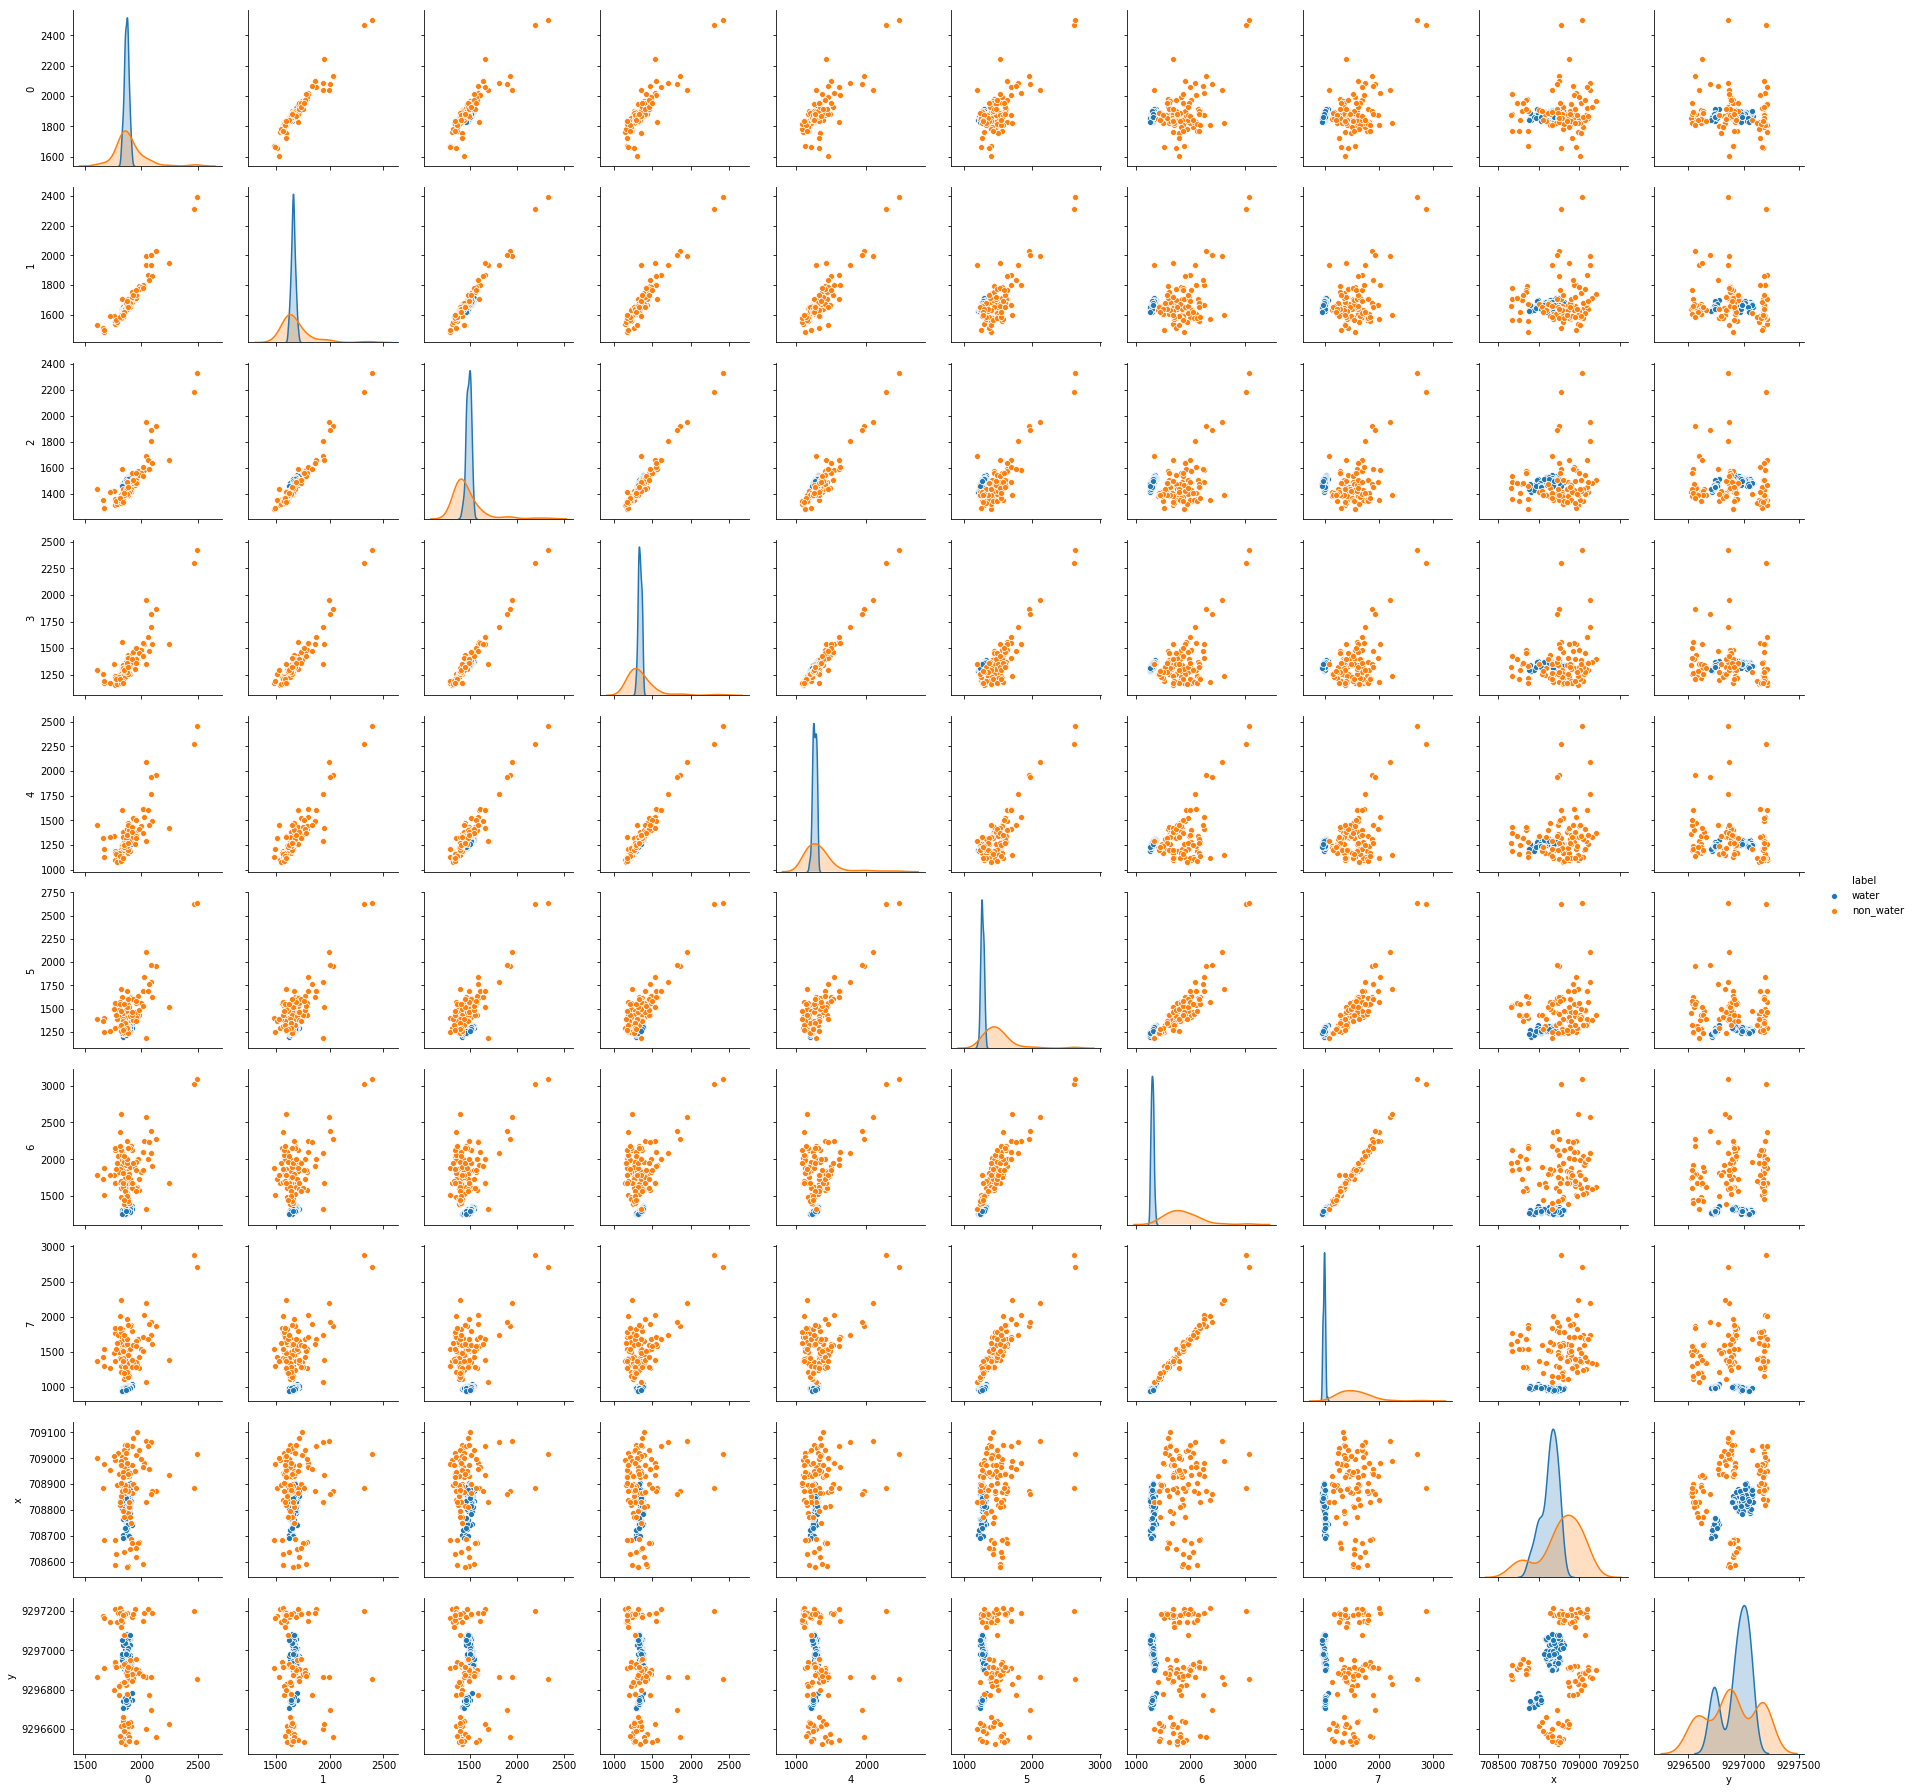

In [10]:
# Create scatterplot matrix to visualize errors
sb.pairplot(data_raw.dropna(), hue='label')

**Step 3: Feature engineering**

There are still some predictors we want to add to our dataset. We'll calculate indices that will help us to distinguish even better between the different land cover classes. We will use the following indices:

**NDVI** =	Normalized Differnce Vegetation Index   
**NDWI** =	Normalised Difference Water Index  
**NDBI** =   Normalized Difference Built-Up Index   
**II** = Iron Index

[Source](https://notebooks.geobigdata.io/hub/notebooks/5a3ad6989b604e2ff535c27b?tab=code)

We will use the band data that we have to calculate the indices. The first 8 columns of our dataset correspond to the following bands:
- 0 = coastal
- 1 = blue
- 2 = green
- 3 = yellow
- 4 = red
- 5 = red_edge
- 6 = nir1
- 7 = nir2

In [11]:
# First we rename the columns of our dataset 

data_raw.columns = ['coastal','blue','green','yellow','red','red_edge','nir1','nir2','x','y','label']
data_raw.head()

,coastal,blue,green,yellow,red,red_edge,nir1,nir2,x,y,label
0,1895.0,1683.0,1511.0,1365.0,1289.0,1296.0,1324.0,1001.0,708789.889179,9.297056e+06,water
1,1882.0,1665.0,1502.0,1358.0,1281.0,1280.0,1290.0,978.0,708817.607101,9.297038e+06,water
2,1872.0,1668.0,1492.0,1333.0,1265.0,1260.0,1281.0,968.0,708866.775840,9.297027e+06,water
3,1860.0,1664.0,1509.0,1359.0,1290.0,1290.0,1316.0,980.0,708808.510150,9.296940e+06,water
4,1866.0,1672.0,1506.0,1357.0,1286.0,1281.0,1299.0,979.0,708826.349904,9.296958e+06,water


In [12]:
# Here we will calculate the indices with the band data we already have

data_raw['ndvi'] = (data_raw.nir1 - data_raw.red)/(data_raw.nir1 + data_raw.red)
data_raw['ndwi'] = (data_raw.green - data_raw.nir1)/(data_raw.green + data_raw.nir1)


data_raw.head()

,coastal,blue,green,yellow,red,red_edge,nir1,nir2,x,y,label,ndvi,ndwi
0,1895.0,1683.0,1511.0,1365.0,1289.0,1296.0,1324.0,1001.0,708789.889179,9.297056e+06,water,0.013395,0.065961
1,1882.0,1665.0,1502.0,1358.0,1281.0,1280.0,1290.0,978.0,708817.607101,9.297038e+06,water,0.003501,0.075931
2,1872.0,1668.0,1492.0,1333.0,1265.0,1260.0,1281.0,968.0,708866.775840,9.297027e+06,water,0.006284,0.076091
3,1860.0,1664.0,1509.0,1359.0,1290.0,1290.0,1316.0,980.0,708808.510150,9.296940e+06,water,0.009977,0.068319
4,1866.0,1672.0,1506.0,1357.0,1286.0,1281.0,1299.0,979.0,708826.349904,9.296958e+06,water,0.005029,0.073797


**Step 4: Cleaning the data**

From the scatterplot matrix, we can conclude that we still need to clean the data:

1. Remove duplicates.
2. Remove click errors.
3. Remove outliers.
4. Remove coordinate data (these data can't be used as predictors).

In [13]:
# 1. Remove duplicates from dataset
# (these pixels were clicked when a label didn't occur in the chunk)

data_clean1 = data_raw.drop_duplicates(subset=['x', 'y'], keep= False)
data_clean1.describe()

,coastal,blue,green,yellow,red,red_edge,nir1,nir2,x,y,ndvi,ndwi
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,2.000000e+02,200.000000,200.000000
mean,1881.390000,1674.390000,1481.620000,1349.020000,1300.625000,1382.115000,1577.990000,1270.290000,708853.645376,9.296919e+06,0.087411,-0.021192
std,94.430682,103.852078,119.801702,146.667537,169.604904,199.449599,357.857907,357.415831,103.990891,1.807238e+02,0.093211,0.102783
min,1605.000000,1480.000000,1286.000000,1150.000000,1082.000000,1185.000000,1249.000000,946.000000,708578.557153,9.296524e+06,0.001186,-0.305736
25%,1847.000000,1636.000000,1418.000000,1296.000000,1236.500000,1262.750000,1299.000000,986.000000,708801.306129,9.296780e+06,0.013076,-0.110351
50%,1872.000000,1662.000000,1480.000000,1336.000000,1271.000000,1295.000000,1358.000000,1059.500000,708854.079080,9.296934e+06,0.026190,0.053947
75%,1893.000000,1684.000000,1508.250000,1365.250000,1311.000000,1452.750000,1818.500000,1520.500000,708903.162347,9.297051e+06,0.133841,0.069274
max,2498.000000,2395.000000,2326.000000,2426.000000,2456.000000,2639.000000,3090.000000,2871.000000,709101.989890,9.297214e+06,0.389965,0.121403


In [14]:
# 2. Remove click errors
# data_clean2a = data_clean1[data_clean1.x != 246]
# data_clean2b = data_clean1[data_clean1.x != 126]
#data_clean2c = data_clean1[data_clean1.x != 208]
#data_clean2d = data_clean1[data_clean1.x != 200]
#data_clean2e = data_clean1[data_clean1.x != 242]
data_clean2 = data_clean1
data_clean2.describe()

,coastal,blue,green,yellow,red,red_edge,nir1,nir2,x,y,ndvi,ndwi
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,2.000000e+02,200.000000,200.000000
mean,1881.390000,1674.390000,1481.620000,1349.020000,1300.625000,1382.115000,1577.990000,1270.290000,708853.645376,9.296919e+06,0.087411,-0.021192
std,94.430682,103.852078,119.801702,146.667537,169.604904,199.449599,357.857907,357.415831,103.990891,1.807238e+02,0.093211,0.102783
min,1605.000000,1480.000000,1286.000000,1150.000000,1082.000000,1185.000000,1249.000000,946.000000,708578.557153,9.296524e+06,0.001186,-0.305736
25%,1847.000000,1636.000000,1418.000000,1296.000000,1236.500000,1262.750000,1299.000000,986.000000,708801.306129,9.296780e+06,0.013076,-0.110351
50%,1872.000000,1662.000000,1480.000000,1336.000000,1271.000000,1295.000000,1358.000000,1059.500000,708854.079080,9.296934e+06,0.026190,0.053947
75%,1893.000000,1684.000000,1508.250000,1365.250000,1311.000000,1452.750000,1818.500000,1520.500000,708903.162347,9.297051e+06,0.133841,0.069274
max,2498.000000,2395.000000,2326.000000,2426.000000,2456.000000,2639.000000,3090.000000,2871.000000,709101.989890,9.297214e+06,0.389965,0.121403


In [15]:
# 3. Remove outliers
outlier = ((data_clean2.ndvi < 0.5) & (data_clean2['label'] == 'tree'))
data_clean3 = data_clean2[[not i for i in outlier]]
data_clean3.describe()

,coastal,blue,green,yellow,red,red_edge,nir1,nir2,x,y,ndvi,ndwi
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,2.000000e+02,200.000000,200.000000
mean,1881.390000,1674.390000,1481.620000,1349.020000,1300.625000,1382.115000,1577.990000,1270.290000,708853.645376,9.296919e+06,0.087411,-0.021192
std,94.430682,103.852078,119.801702,146.667537,169.604904,199.449599,357.857907,357.415831,103.990891,1.807238e+02,0.093211,0.102783
min,1605.000000,1480.000000,1286.000000,1150.000000,1082.000000,1185.000000,1249.000000,946.000000,708578.557153,9.296524e+06,0.001186,-0.305736
25%,1847.000000,1636.000000,1418.000000,1296.000000,1236.500000,1262.750000,1299.000000,986.000000,708801.306129,9.296780e+06,0.013076,-0.110351
50%,1872.000000,1662.000000,1480.000000,1336.000000,1271.000000,1295.000000,1358.000000,1059.500000,708854.079080,9.296934e+06,0.026190,0.053947
75%,1893.000000,1684.000000,1508.250000,1365.250000,1311.000000,1452.750000,1818.500000,1520.500000,708903.162347,9.297051e+06,0.133841,0.069274
max,2498.000000,2395.000000,2326.000000,2426.000000,2456.000000,2639.000000,3090.000000,2871.000000,709101.989890,9.297214e+06,0.389965,0.121403


In [16]:
# 4. Remove coordinate values from dataset
# these variables can't be used to predict the land cover type
data_clean4 = data_clean3.drop(columns=['x','y'])
data_clean4.describe()

,coastal,blue,green,yellow,red,red_edge,nir1,nir2,ndvi,ndwi
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1881.390000,1674.390000,1481.620000,1349.020000,1300.625000,1382.115000,1577.990000,1270.290000,0.087411,-0.021192
std,94.430682,103.852078,119.801702,146.667537,169.604904,199.449599,357.857907,357.415831,0.093211,0.102783
min,1605.000000,1480.000000,1286.000000,1150.000000,1082.000000,1185.000000,1249.000000,946.000000,0.001186,-0.305736
25%,1847.000000,1636.000000,1418.000000,1296.000000,1236.500000,1262.750000,1299.000000,986.000000,0.013076,-0.110351
50%,1872.000000,1662.000000,1480.000000,1336.000000,1271.000000,1295.000000,1358.000000,1059.500000,0.026190,0.053947
75%,1893.000000,1684.000000,1508.250000,1365.250000,1311.000000,1452.750000,1818.500000,1520.500000,0.133841,0.069274
max,2498.000000,2395.000000,2326.000000,2426.000000,2456.000000,2639.000000,3090.000000,2871.000000,0.389965,0.121403


In [17]:
data_clean = data_clean4

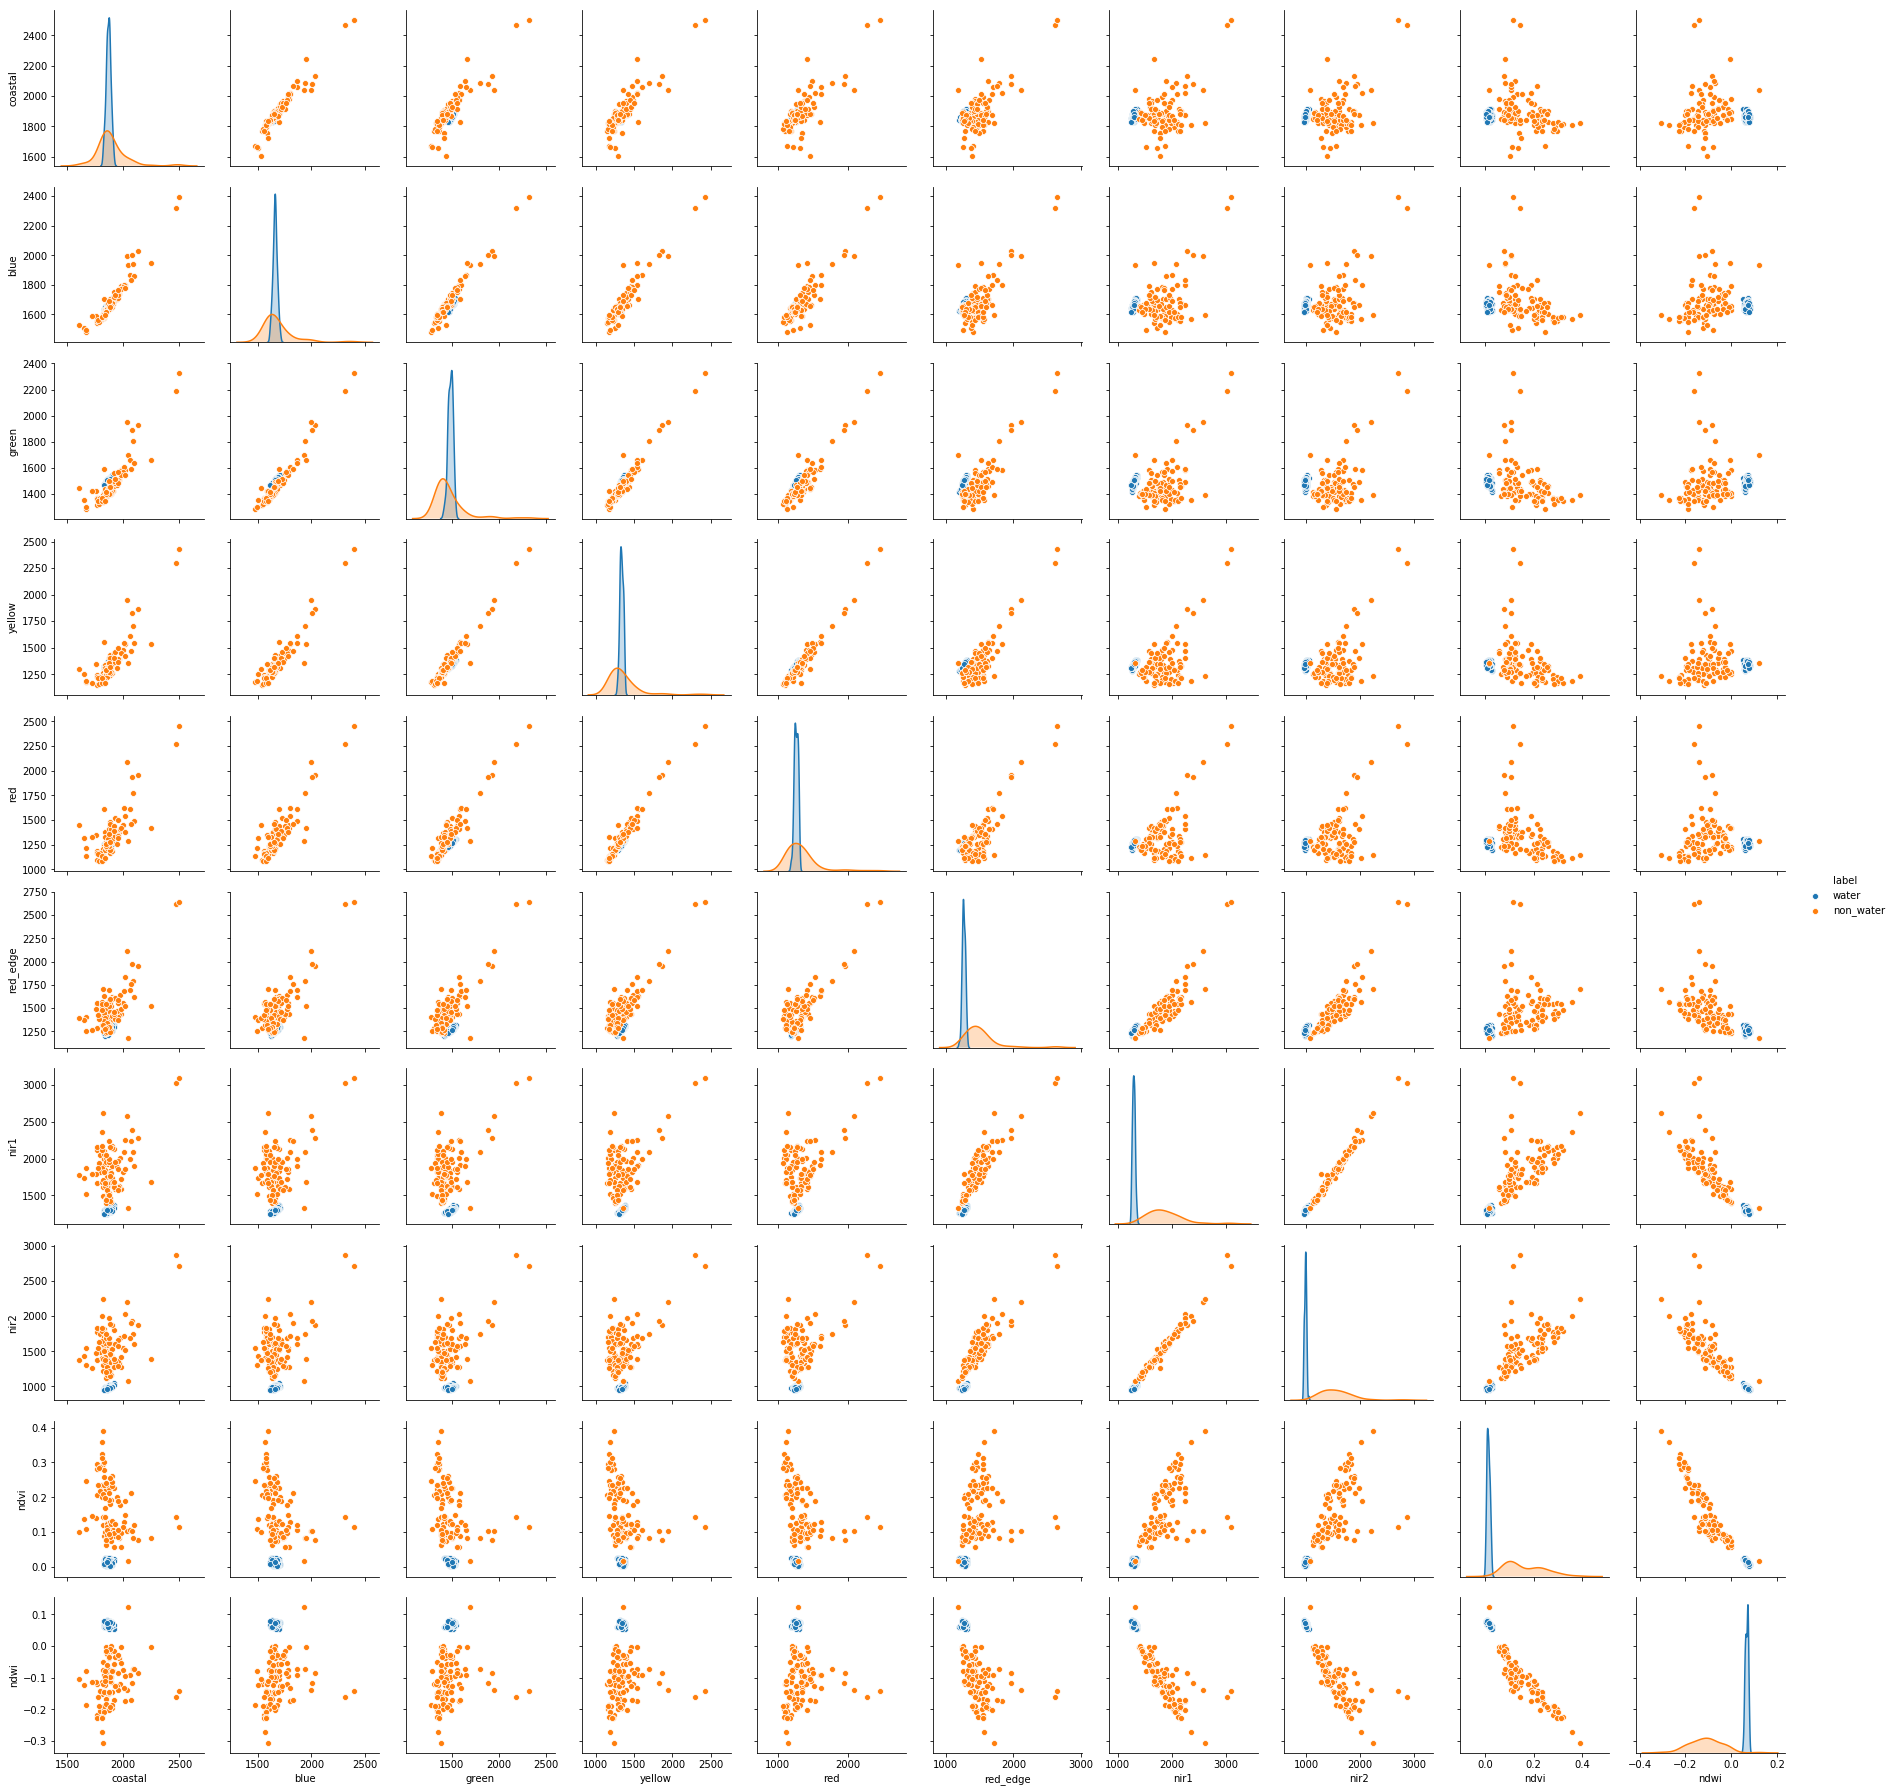

In [18]:
sb.pairplot(data_clean, hue='label')
plt.show()

**Step 5: Exploratory analysis**

In this part we start the analysis. We check how the data is distributed, if there are any correlations and if there are confounding variables.

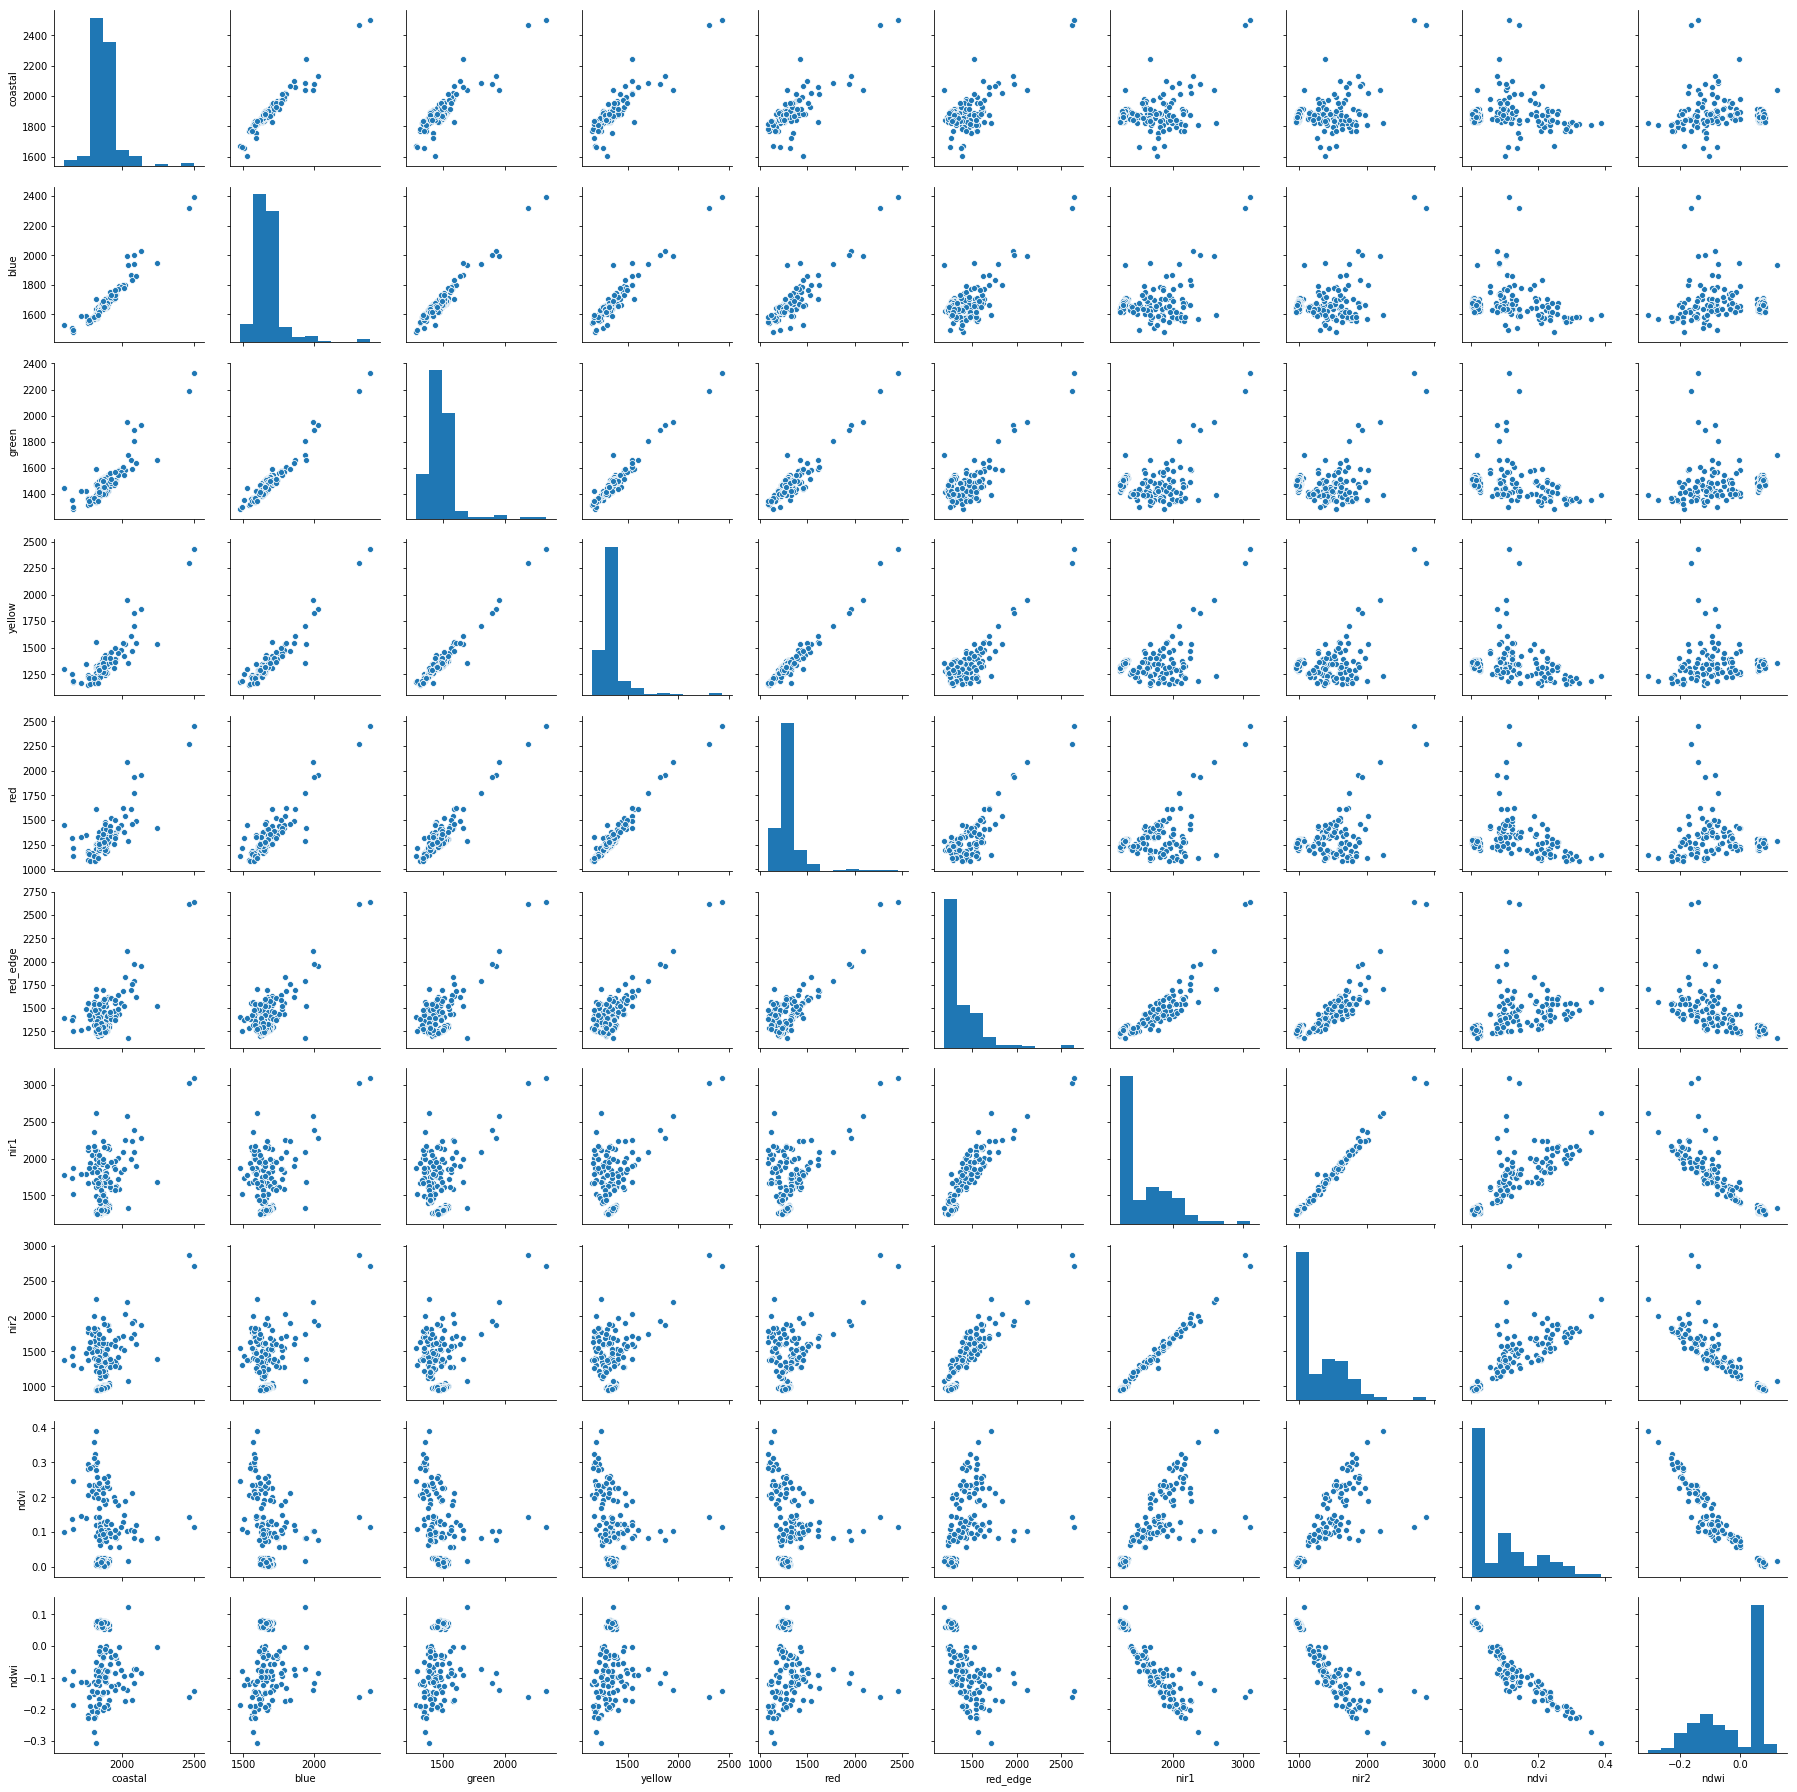

In [19]:
# Create simple scatterplot

sb.pairplot(data_clean)

''

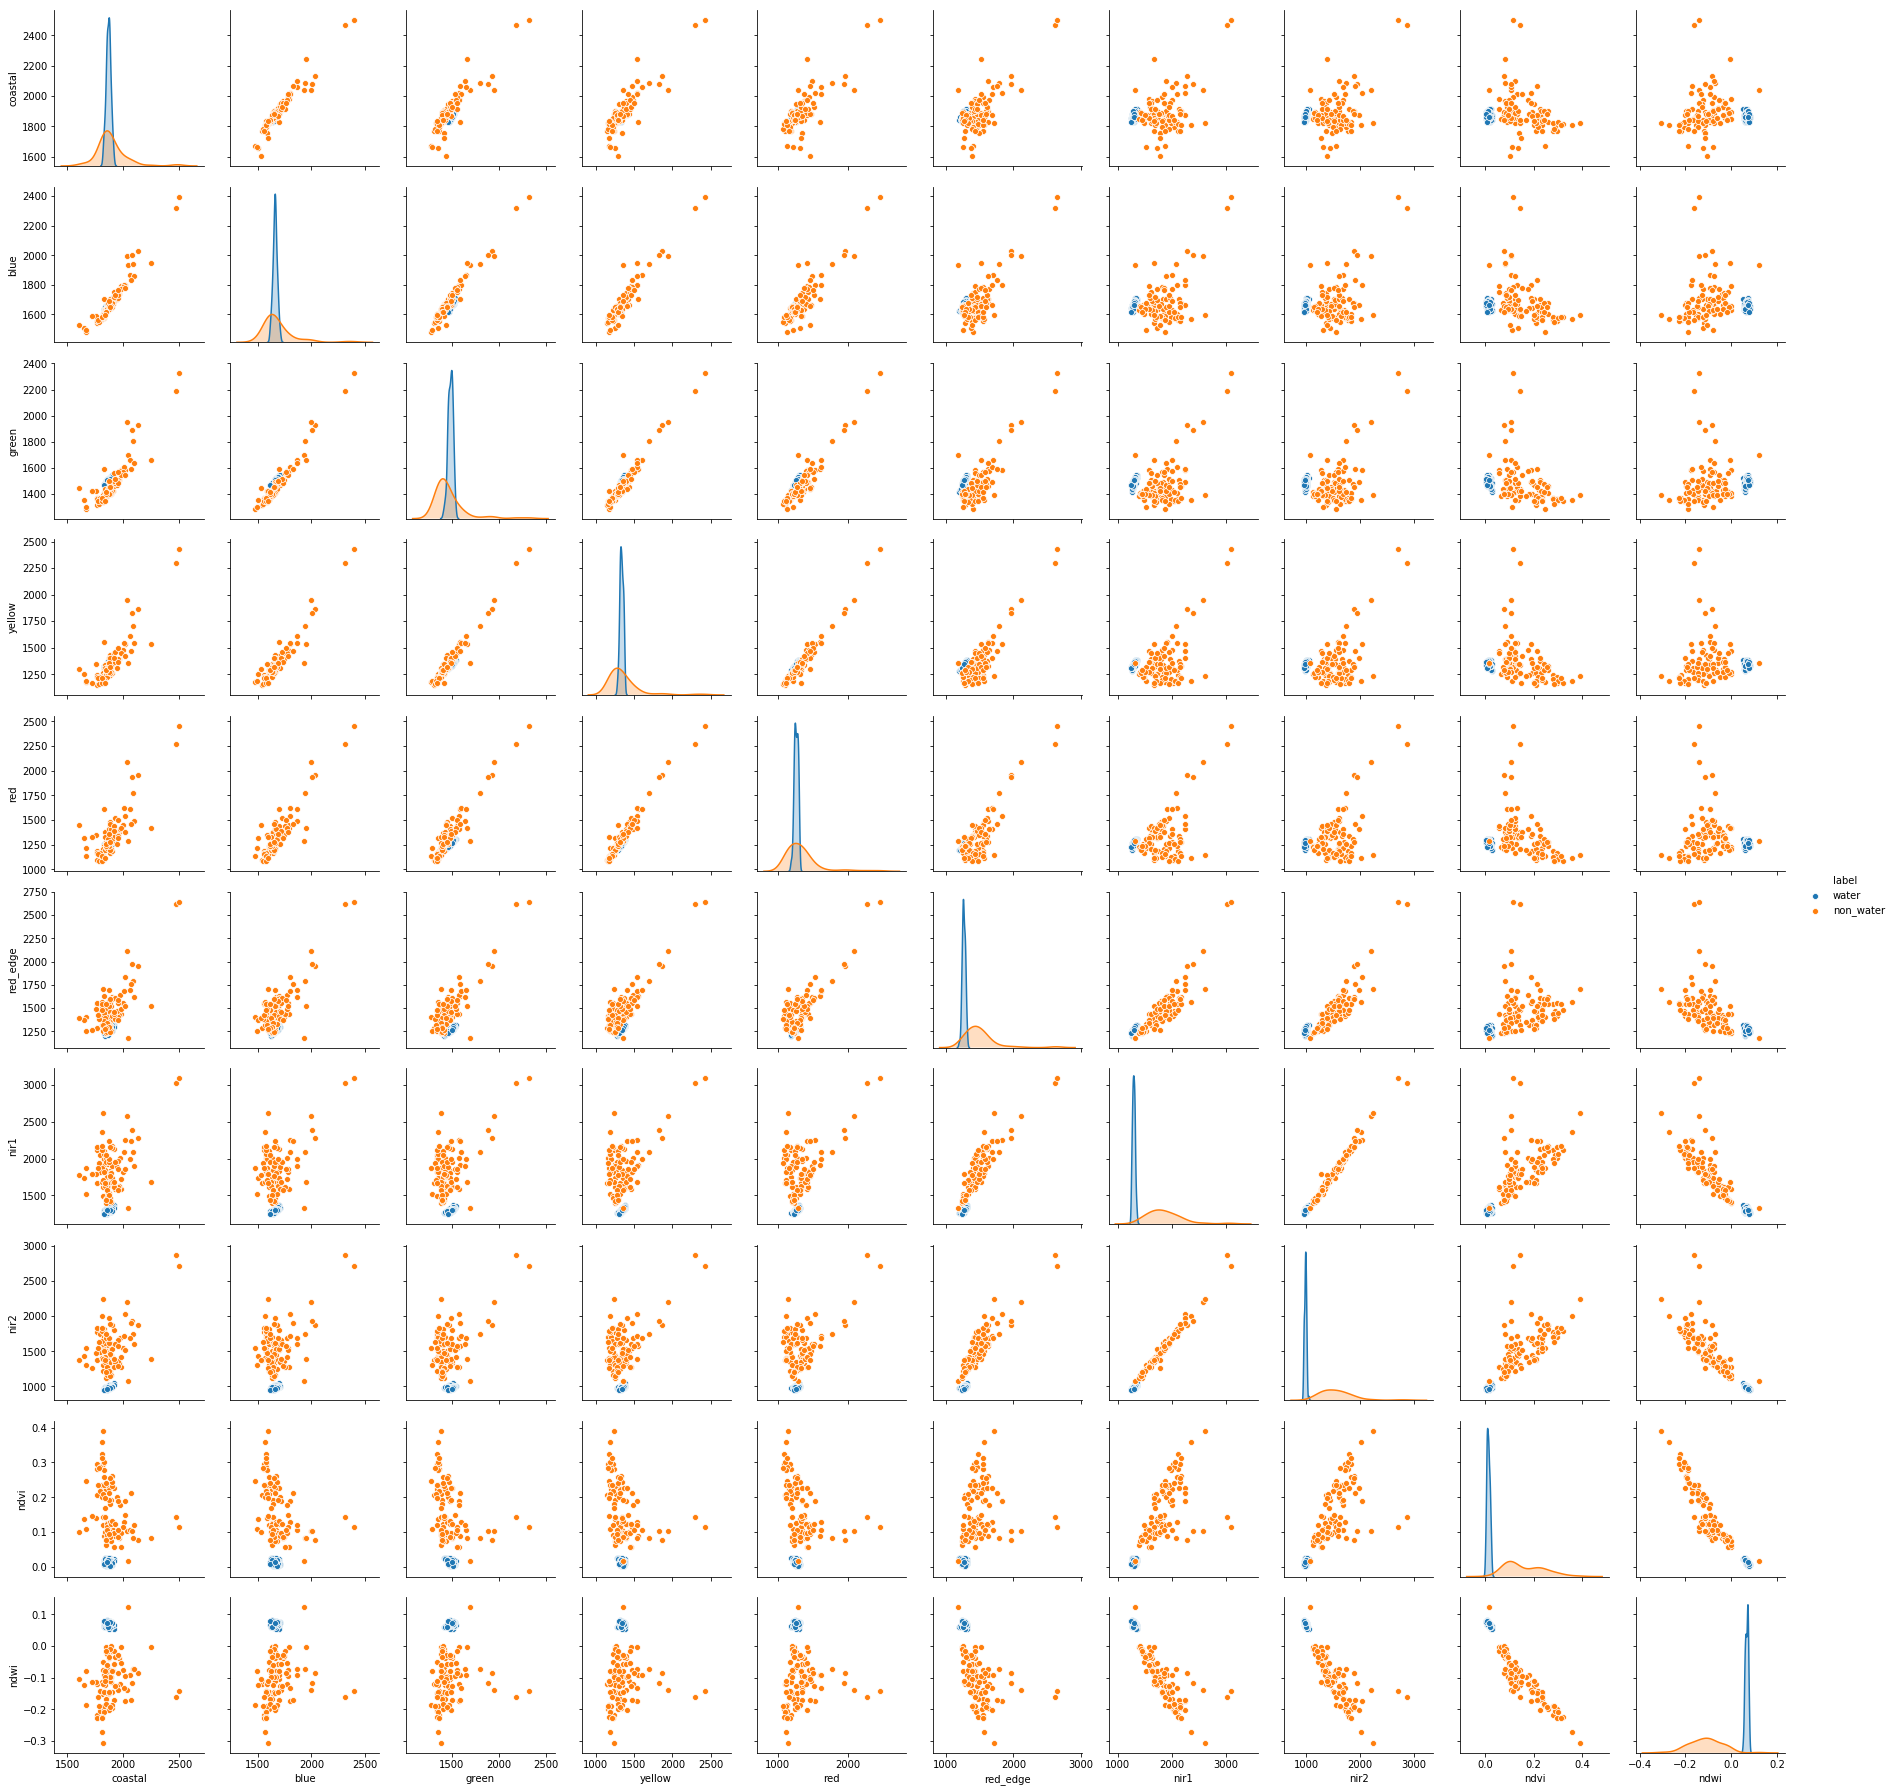

In [20]:
# Create scatterplot coloured per label

sb.pairplot(data_clean, hue='label')
;

/anaconda/envs/gbdx_py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


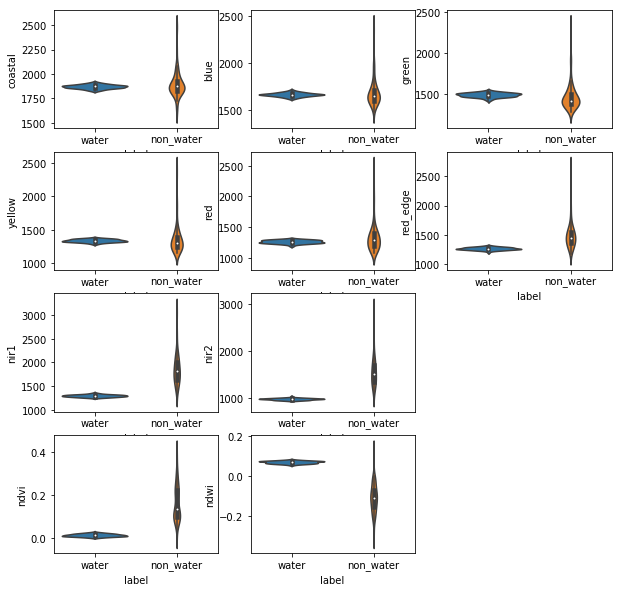

In [21]:
# Create violin plots per predictor

plt.figure(figsize=(10, 10))

for column_index, column in enumerate(data_clean.columns):
    if column == 'label':
        continue
    plt.subplot(4,3, column_index + 1)
    sb.violinplot(x='label', y=column, data=data_clean)

**Step 6: Classifier testing**

In this part we start modeling. We split the data into training and testing sets.

- A training set is a random subset of the data that we use to train our models.
- A testing set is a random subset of the data (mutually exclusive from the training set) that we use to validate our models on unforseen data.

We test de following models:

- Basic decision tree
- Random forest
- Naive bayes
- XGBoost

In [22]:
# We're using all band measurements as inputs
# Note that scikit-learn expects each entry to be a list of values, e.g.,
# [ [val1, val2, val3],
#   [val1, val2, val3],
#   ... ]
# such that our input data set is represented as a list of lists

# We can extract the data in this format from pandas like this:
X = data_clean[['coastal','blue', 'green','yellow', 'red','red_edge','nir1','nir2','ndvi','ndwi']].values

# Similarly, we can extract the labels
y = data_clean['label'].values

# Make sure that you don't mix up the order of the entries
# all_inputs[5] inputs should correspond to the label in all_labels[5]

# Here's what a subset of our inputs looks like:
X[:5]

array([[1.89500000e+03, 1.68300000e+03, 1.51100000e+03, 1.36500000e+03,
        1.28900000e+03, 1.29600000e+03, 1.32400000e+03, 1.00100000e+03,
        1.33945656e-02, 6.59611993e-02],
       [1.88200000e+03, 1.66500000e+03, 1.50200000e+03, 1.35800000e+03,
        1.28100000e+03, 1.28000000e+03, 1.29000000e+03, 9.78000000e+02,
        3.50058343e-03, 7.59312321e-02],
       [1.87200000e+03, 1.66800000e+03, 1.49200000e+03, 1.33300000e+03,
        1.26500000e+03, 1.26000000e+03, 1.28100000e+03, 9.68000000e+02,
        6.28436764e-03, 7.60908763e-02],
       [1.86000000e+03, 1.66400000e+03, 1.50900000e+03, 1.35900000e+03,
        1.29000000e+03, 1.29000000e+03, 1.31600000e+03, 9.80000000e+02,
        9.97697621e-03, 6.83185841e-02],
       [1.86600000e+03, 1.67200000e+03, 1.50600000e+03, 1.35700000e+03,
        1.28600000e+03, 1.28100000e+03, 1.29900000e+03, 9.79000000e+02,
        5.02901354e-03, 7.37967914e-02]])

In [23]:
# We need to make sure that no variables are strings, so we need to transform 

# Import LabelEncoder
from sklearn import preprocessing

# Creating labelEncoder
le = preprocessing.LabelEncoder()

# Converting string labels into numbers.
y_encoded=le.fit_transform(y)

print(y_encoded)

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# Split the dataset into training and testing sets

from sklearn.model_selection import train_test_split          # If error pip install sklearn in terminal

(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(X, y_encoded, test_size=0.25, random_state=1)

**Decision tree classifier**

In [ ]:
# Fit decision tree model

from sklearn.tree import DecisionTreeClassifier

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(X_train, y_train)

# Validate the classifier on the testing set using classification accuracy
decision_tree_classifier.score(X_test, y_test)

What percentage of accuracy did the model achieve?

There's a catch: Depending on how our training and testing set was sampled, our model can achieve anywhere from 80% to 100% accuracy:

In [ ]:
# Visualize possible model accuracies

model_accuracies = []

for repetition in range(1000):
    (X_train,
     X_test,
     y_train,
     y_test) = train_test_split(X, y, test_size=0.25)
    
    decision_tree_classifier = DecisionTreeClassifier()
    decision_tree_classifier.fit(X_train, y_train)
    classifier_accuracy = decision_tree_classifier.score(X_test, y_test)
    model_accuracies.append(classifier_accuracy)
    
plt.hist(model_accuracies)
;

It's obviously a problem that our model performs quite differently depending on the subset of the data it's trained on. This phenomenon is known as overfitting: The model is learning to classify the training set so well that it doesn't generalize and perform well on data it hasn't seen before.

**Cross-validation**

This problem is the main reason that most data scientists perform k-fold cross-validation on their models: Split the original data set into k subsets, use one of the subsets as the testing set, and the rest of the subsets are used as the training set. This process is then repeated k times such that each subset is used as the testing set exactly once.

10-fold cross-validation is the most common choice, so let's use that here. Performing 10-fold cross-validation on our data set looks something like this:

(each square is an entry in our data set)

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(masks, interpolation='none', cmap='gray_r')
    plt.ylabel('Fold')
    plt.xlabel('Row #')

plot_cv(StratifiedKFold(n_splits=10), X, y)


We can perform 10-fold cross-validation on our model with the following code:

In [ ]:
from sklearn.model_selection import cross_val_score

decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, X, y, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
;

**Parameter tuning**
Every Machine Learning model comes with a variety of parameters to tune, and these parameters can be vitally important to the performance of our classifier. For example, if we severely limit the depth of our decision tree classifier:

In [ ]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=1)

cv_scores = cross_val_score(decision_tree_classifier, X, y, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
;

the classification accuracy falls tremendously.

Therefore, we need to find a systematic method to discover the best parameters for our model and data set.

The most common method for model parameter tuning is Grid Search. The idea behind Grid Search is simple: explore a range of parameters and find the best-performing parameter combination. Focus your search on the best range of parameters, then repeat this process several times until the best parameters are discovered.

Let's tune our decision tree classifier. We'll stick to only two parameters for now, but it's possible to simultaneously explore dozens of parameters if we want.

In [ ]:
from sklearn.model_selection import GridSearchCV

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

dt_grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

dt_grid_search.fit(X, y)
print('Best score: {}'.format(dt_grid_search.best_score_))
print('Best parameters: {}'.format(dt_grid_search.best_params_))

Now let's visualize the grid search to see how the parameters interact.

In [ ]:
dt_grid_visualization = dt_grid_search.cv_results_['mean_test_score']
dt_grid_visualization.shape = (5, 4)
sb.heatmap(dt_grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(4) + 0.5, dt_grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, dt_grid_search.param_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')
;

Let's go ahead and use a broad grid search to find the best settings for a handful of parameters.

In [ ]:
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

dt_grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

dt_grid_search.fit(X, y)
print('Best score decision tree: {}'.format(dt_grid_search.best_score_))
print('Best parameters decision tree: {}'.format(dt_grid_search.best_params_))

In [ ]:
# Classification report decision tree classifier

from sklearn.metrics import classification_report

y_pred = dt_grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
# Confusion matrix decision tree classifier

from sklearn.metrics import confusion_matrix

y_pred = dt_grid_search.predict(X_test)
print(confusion_matrix(y_test, y_pred))

**Random forest classifier**

In [ ]:
# Fit random forest classifier

from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier()

parameter_grid = {'n_estimators': [10, 25, 50, 100],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

rf_grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

rf_grid_search.fit(X, y)
print('Best score random forest classifier: {}'.format(rf_grid_search.best_score_))
print('Best parameters random forest classifier: {}'.format(rf_grid_search.best_params_))

rf_grid_search.best_estimator_

In [ ]:
# Classification report random forest classifier

from sklearn.metrics import classification_report

y_pred = rf_grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
# Confusion matrix random forest classifier

from sklearn.metrics import confusion_matrix

y_pred = rf_grid_search.predict(X_test)
print(confusion_matrix(y_test, y_pred))

**Naive Bayes classifier**

In [ ]:
# Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Classifier 
naive_bayes_classifier = GaussianNB()

# Train the model using the training sets
naive_bayes_classifier.fit(X_train,y_train)

# Predict Output
y_pred= naive_bayes_classifier.predict(X_test)

# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
from sklearn.metrics import accuracy_score

naive_bayes_classifier_accuracy = accuracy_score(y_test, y_pred)
print(naive_bayes_classifier_accuracy)

In [ ]:
# Classification report naive bayes classifier

from sklearn.metrics import classification_report

y_pred = naive_bayes_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
# Confusion matrix naive bayes classifier

from sklearn.metrics import confusion_matrix

y_pred = naive_bayes_classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))

**XGBoost classifier**

In [ ]:
# Create the Xgboost specific DMatrix data format from the numpy array

# import xgboost as xgb

# data_dmatrix = xgb.DMatrix(data=X,label=y_encoded)

In [ ]:
# Fit XGBoost classifier

# from sklearn.metrics import accuracy_score

# xgboost_classifier = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
# xgboost_classifier.fit(X_train, y_train)

# y_pred = xgboost_classifier.predict(X_test)

# xgboost_classifier_accuracy = accuracy_score(y_test, y_pred)
# print(xgboost_classifier_accuracy)

In [ ]:
# parameter_grid = {'n_estimators': [10, 25, 50, 100],
#                   'criterion': ['gini', 'entropy'],
#                   'max_features': [1, 2, 3, 4]}

# cross_validation = StratifiedKFold(n_splits=10)

# xgb_grid_search = GridSearchCV(xgboost_classifier,
#                            param_grid=parameter_grid,
#                            cv=cross_validation)

# xgb_grid_search.fit(X, y)
# print('Best score xgboost classifier: {}'.format(xgb_grid_search.best_score_))
# print('Best parameters xgboost classifier: {}'.format(xgb_grid_search.best_params_))

# xgb_grid_search.best_estimator_

In [ ]:
# Classification report XGBoost classifier

# from sklearn.metrics import classification_report

# y_pred = xgboost_classifier.predict(X_test)
# print(classification_report(y_test, y_pred))

In [ ]:
# Confusion matrix XGBoost classifier

# from sklearn.metrics import confusion_matrix

# y_pred = xgboost_classifier.predict(X_test)
# print(confusion_matrix(y_test, y_pred))

**Compare performance of classifiers**

In [ ]:
# Summary of model results

print('Best score decision tree: {}'.format(dt_grid_search.best_score_))
print('Best parameters decision tree: {}'.format(dt_grid_search.best_params_))

print('Best score random forest: {}'.format(rf_grid_search.best_score_))
print('Best parameters random forest: {}'.format(rf_grid_search.best_params_))

print('Best score naive bayes:'.format(naive_bayes_classifier_accuracy))

#print('Best score xgboost: {}'.format(xgb_grid_search.best_score_))

In [ ]:
# Compare performance classifiers

random_forest_classifier = rf_grid_search.best_estimator_

rf_df = pd.DataFrame({'accuracy': cross_val_score(random_forest_classifier, X, y, cv=10),
                       'classifier': ['Random Forest'] * 10})
dt_df = pd.DataFrame({'accuracy': cross_val_score(decision_tree_classifier, X, y, cv=10),
                      'classifier': ['Decision Tree'] * 10})
both_df = rf_df.append(dt_df)

sb.boxplot(x='classifier', y='accuracy', data=both_df)
sb.stripplot(x='classifier', y='accuracy', data=both_df, jitter=True, color='black')
;

**Step 7: Classification**

In this part we'll use the classifier with the highest accuracy to classify our satellite image. 

In [ ]:
rf_grid_search.predict(X)

In [ ]:
# Import image

from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline



catalog_id = env.inputs.get('catalog_id', '1030010099845B00')
bbox = env.inputs.get('bbox', '106.884, -6.362, 106.893, -6.353')



bbox1 = list(map(float, bbox.split(",")))

# get a projected coordinate system for plotting
EPSG = 32700-round((45+list(bbox1)[1])/90,0)*100+round((183+list(bbox1)[0])/6,0)
UTM_EPSG_code ='EPSG:%i'  % (EPSG)

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")), proj = UTM_EPSG_code, pansharpen = True)

acquisitionDate = image.metadata["image"]["acquisitionDate"]

print("  taken on {}".format(acquisitionDate))


image.plot(w=10, h=10)

# Transform dask array to array
image_array = image.read()
data = image_array

In [ ]:
# Write geotiff to file for download

# image.geotiff(path="Setu_Babakan_pansharpen_{}.tif".format(acquisitionDate))

In [ ]:
from skimage import exposure
from skimage.filters import threshold_otsu, threshold_local
import matplotlib.pyplot as plt


blocksize = 9

# Split image data into band layers
coastal = threshold_local(data[0], blocksize, offset=0) 
blue    = threshold_local(data[1], blocksize, offset=0) 
green   = threshold_local(data[2], blocksize, offset=0) 
yellow  = threshold_local(data[3], blocksize, offset=0)
red     = threshold_local(data[4], blocksize, offset=0) 
red_edge = threshold_local(data[5], blocksize, offset=0) 
nir1 = threshold_local(data[6], blocksize, offset=0)
nir2 = threshold_local(data[7], blocksize, offset=0) 

              


In [ ]:
import numpy as np

# Split image data into band layers

# coastal = data[0]
# blue = data[1]
# green = data[2]
# yellow = data[3]
# red = data[4]
# red_edge = data[5]
# nir1 = data[6]
# nir2 = data[7]

In [ ]:
# Calculate indices

ndvi = (nir1 - red)/(nir1 + red)
ndwi = (green - nir1) / (green + nir1)


# Create function that reshapes numpy arrays

def reshape(index):
    index = np.reshape(index,[1,index.shape[0],index.shape[1]])
    return(index)

# Make sure ndvi and ndwi are stackable with band data by making them 3-dimensional (1,x,y)
ndvi = reshape(ndvi)
ndwi = reshape(ndwi)


# Stack arrays in sequence vertically (row wise)

image_array = np.vstack([data,ndvi,ndwi])

In [ ]:
# Calculate 3-dimensional shape of new image_array
n_bands, rows, cols = image_array.shape

# Calculate number of pixels/samples
n_samples = rows*cols

# Create table where every row represents the data in one pixel/sample
reshaped_data = image_array.reshape(n_bands,(rows*cols))

#Remove NAN values
reshaped_data[np.isnan(reshaped_data)] = 0

In [ ]:
# Predict class of image
result = rf_grid_search.predict(reshaped_data.T)
classification = result.T.T.T.reshape((rows, cols))

In [ ]:
# Get classnames and corresponding indices
classnames, indices = np.unique(classification, return_inverse=True)

print(classnames)
print(np.unique(indices))

In [ ]:
classification_plot = indices.reshape((rows, cols))

classification_plot = classification_plot + 1

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import pyplot as plt
from matplotlib import colors

f = plt.figure( figsize = (20,20))

f.add_subplot(1, 2, 1)
plt.imshow(image.rgb())
f.add_subplot(1, 2, 2)
cmap = colors.ListedColormap(['tomato', 'palegreen', 'navajowhite', 'forestgreen', 'lightskyblue'])
im = plt.imshow(classification_plot,cmap)

plt.colorbar(im,fraction=0.046, pad=0.04)





#cmap = colors.ListedColormap(['red', 'limegreen', 'dimgrey', 'green', 'blue'])
        
#f2, ax = plt.subplots( figsize = (10,10))

#cax = ax.imshow(classification_plot, cmap=cmap, vmin=0, vmax=5)

#cbar = f2.colorbar(cax, ticks=[1, 2, 3, 4, 5])
#cbar.ax.set_xticklabels(['building', 'grass', 'street', 'tree', 'water'])

In [134]:
import itertools

# Shapely and Rasterio for processing geometries
from shapely import geometry
from shapely.geometry import box, shape, Polygon
from shapely.ops import cascaded_union
from rasterio import features   

# GBDX
from gbdxtools import Interface

# array operations and plotting
import numpy as np
import matplotlib.pyplot as plt

# scikit-image modules for image science operators
from skimage import filters, morphology

# Initialize gbdx interface
gbdx = Interface()

In [135]:

classification_plot[classification_plot == 1] = 0
classification_plot[classification_plot == 2] = 1

In [163]:
# Specify the minimum feature size in square meters, and then use info from the image metadata 
# to translate to grid cell count.

# Set the minimum feature size to 400 sq km (400,000 m)
min_feature_size_m2 = 50000.

# From the image metadata, we can determine the area of a single grid cell
cell_height_m = image.rda.metadata['image']['groundSampleDistanceMeters']
cell_area_m2 = cell_height_m**2

# Finally, use the cell size to convert the minimum feature size to grid cells
min_feature_size_cells = np.round((min_feature_size_m2/cell_area_m2)).astype('int64')

# What is the minimum feature size in square meters and grid cells?
print(min_feature_size_m2, 'sq. m')
print(min_feature_size_cells, 'grid cells')

50000.0 sq. m
219752 grid cells


In [164]:
# First, remove the small holes
water_cleaned = morphology.remove_small_holes(classification_plot, min_feature_size_cells)

# Then remove the small objects
water_cleaned = morphology.remove_small_objects(water_cleaned, min_feature_size_cells, connectivity=2)

In [165]:
# Also extract the visible color (i.e., Red-Green-Blue) bands, which we'll use for side-by-side plotting as we proceed
rgb = image.rgb()

Text(0.5, 1.0, 'Cleaned Water Mask')

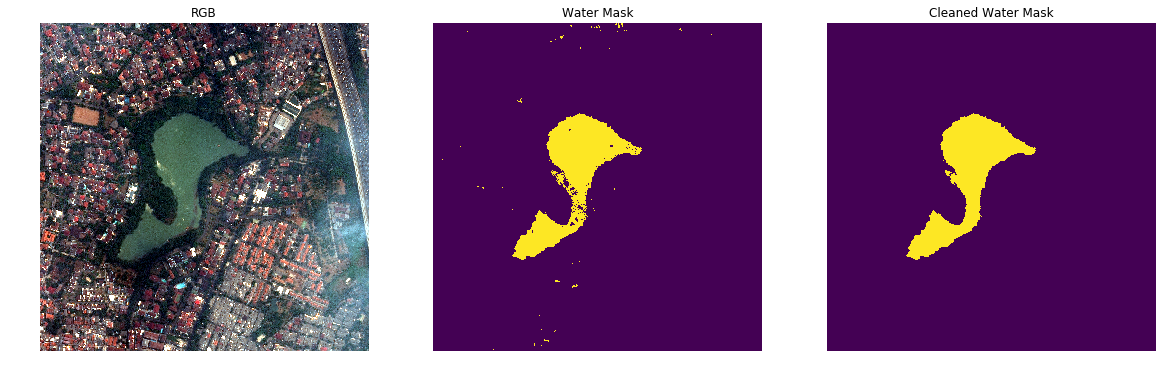

In [166]:
# View the results
plt.figure(figsize=(20,15))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(rgb)
plt.title("RGB")

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(classification_plot, vmin=0, vmax=1)
plt.title("Water Mask")

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(water_cleaned, vmin=0, vmax=1)
plt.title("Cleaned Water Mask")

In [144]:
def array_to_linestrings(array, mask, affine):
    
    if np.all(mask) == True:
        final_lines = []
    else:
        # Convert the array to polygon geometries
        polygon_generator = features.shapes(array.astype('uint8'), mask=array, transform=affine)
        # Extract out the individual polygons, fixing any invald geometries using buffer(0)
        polygons = [shape(g).buffer(0) for g,v in polygon_generator]

        # Next, build up a binary array representing the outer boundary of the input array
        boundary_array = np.ones(array.shape)    

        # Convert the boundary to a polygon too
        boundary_generator = features.shapes(boundary_array.astype('uint8'), transform=affine)
        boundary = [shape(g) for g,v in boundary_generator][0]

        # Convert the mask to a polygon too
        if mask is not None:
            
            mask_generator = features.shapes(mask.astype('uint8'), 
                                             mask= mask > 0,
                                             transform=affine)
            mask_boundary = [shape(g).buffer(0) for g,v in mask_generator][0]

        # Convert the array polygons to linestrings
        exterior_rings = [g.exterior for g in polygons]
        interior_rings = list(itertools.chain.from_iterable([[i for i in g.interiors] for g in polygons if len(g.interiors) > 0]))
        all_rings =  exterior_rings + interior_rings 

        # Erase both the image boundary and the mask boundary from the extracted Linestrings
        erased_lines = [g.difference(boundary.exterior).difference(mask_boundary.exterior) for g in all_rings]
        singlepart_lines = [list(g) if type(g) == geometry.multilinestring.MultiLineString else [g] for g in erased_lines ]
        final_lines = list(itertools.chain(*singlepart_lines))

    return final_lines 


In [145]:
image.metadata['georef']

{'spatialReferenceSystemCode': 'EPSG:32748',
 'scaleX': 0.477,
 'scaleY': -0.477,
 'translateX': 700191.4961086066,
 'translateY': 9339626.69280726,
 'shearX': 0.0,
 'shearY': 0.0}

In [146]:
water_lines = array_to_linestrings(array = water_cleaned, mask = water_cleaned, affine = image.affine)

# Run a basic simplification algorithm to smooth the lines
water_lines_smooth = [g.simplify(image.affine.a) for g in water_lines]
    
# # Finally, take a look at them on a slippy map
# c = gbdx.vectors.map([{'geometry':x.__geo_interface__} for x in water_lines_smooth])

In [147]:
# GLue it all together
setu = cascaded_union(water_lines_smooth)


# # Finally, take a look at them on a slippy map
# c = gbdx.vectors.map([{'geometry':u.__geo_interface__}])

In [148]:
from shapely import geometry, ops

setu = ops.linemerge(setu)

In [149]:
len(setu)

163

In [150]:
import pyproj
from shapely.ops import transform
from functools import partial



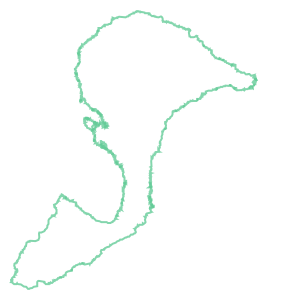

In [151]:
setu

In [152]:
s = setu.simplify(4, preserve_topology=False)

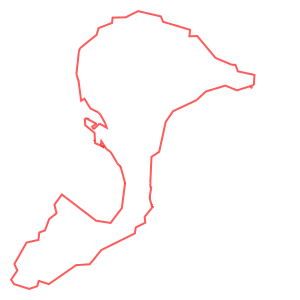

In [153]:
s

In [154]:
import folium

In [155]:
bbox_list_str = bbox.split(',')

In [156]:
bbox = [float(bbox_list_str[0]),float(bbox_list_str[1]),float(bbox_list_str[2]),float(bbox_list_str[3])]
trees = classification_plot == 2

In [157]:
from shapely.ops import transform
from functools import partial
import pyproj

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:32748'),
    pyproj.Proj(init='epsg:4326'))



setu_wgs = transform(project, setu)


setu_smooth = setu_wgs.simplify(0.00003)
setu_poly = ops.polygonize_full(setu_wgs)[0]

In [158]:
setu_smooth_utm = setu.simplify(8)

In [159]:
m = folium.Map([(bbox[1] + bbox[3])/2, (bbox[0] + bbox[2])/2],  zoom_start = 16, 
               tiles = 'https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png',
              attr='CartoDB', name = 'cartocdn')

folium.TileLayer('https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',attr='esri', name = 'esri Imagery').add_to(m)


# folium.raster_layers.ImageOverlay(
#     image=image.rgb(),
#     name='image 2017',
#     bounds=[[bbox[1], bbox[0]],[bbox[3],bbox[2]]],
#     opacity=1,
#     interactive=False,
#     cross_origin=False,
#     zindex=1, 
#     colormap=lambda x: (0,0,0, x)
# ).add_to(m)

# folium.raster_layers.ImageOverlay(
#     image=classification_plot,
#     name='Classification 2017',
#     bounds=[[bbox[1], bbox[0]],[bbox[3],bbox[2]]],
#     opacity=1,
#     interactive=False,
#     cross_origin=False,
#     zindex=1, 
#     colormap=lambda x: (0,x,x, 1)
# ).add_to(m)


folium.Choropleth(setu_wgs, name = 'Setu water delineation').add_to(m)

folium.Choropleth(setu_smooth, name = 'Smooth setu delineation').add_to(m)

folium.Choropleth(setu_poly, name = 'setu poly').add_to(m)

# f_smooth = [0.00001,0.00002,0.00003,0.00004,0.00006,0.00008]

# for i in f_smooth:
#     setu_smooth = setu_wgs.simplify(i)
#     folium.Choropleth(setu_smooth, name = 'smooth setu delineation'.format(i)).add_to(m)
# # 

# for point in range(0, len(locationlist)):
#     folium.Marker(locationlist[point], popup=df['ActualDBH'][point], group  = "Tree removals").add_to(m)

folium.LayerControl().add_to(m)

In [160]:
m

In [161]:
# m.save('classification_water_Setu_Babakan_v1.html')

In [162]:
from shapely.geometry import mapping, Polygon
import fiona

# Here's an example Shapely geometry
poly = Polygon([(0, 0), (0, 1), (1, 1), (0, 0)])

# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}


filename = 'RawaIndah.shp'


# Write a new Shapefile
with fiona.open(filename, 'w', 'ESRI Shapefile', schema) as c:
    ## If there are multiple geometries, put the "for" loop here
    
    for poly in setu_poly:
        c.write({
            'geometry': mapping(poly),
            'properties': {'id': 123},
        })
        
    print('shapefile created')

shapefile created


In [106]:
# load libraries
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry import Point
from shapely.geometry import shape

import fiona

In [ ]:
# load polygons
path = filename
shape_crs = fiona.open(path)
Multi = MultiPolygon([shape(pol['geometry']) for pol in fiona.open(path)]) 

min_x, min_y, max_x, max_y = Multi.bounds

Multi